## This notebook demonstrates running BiPCA on the 3k pbmc scrna-seq data from scanpy

### 1. load data

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc


from multiprocessing import Pool
import matplotlib.pyplot as plt
from tqdm.contrib.concurrent import thread_map,process_map
from functools import partial
import torch
from threadpoolctl import threadpool_limits


import bipca
from bipca import plotting


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages

In [9]:
adata = sc.datasets.pbmc3k()

/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/anndata/__init__.py:52: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [10]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [11]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 2286884 stored elements and shape (2700, 32738)>

### 2. sparsity filtering

In [5]:
from bipca.utils import stabilize_matrix

In [16]:
# here we remove the cells and genes that have more than 100 zero entries
# X_sub is the filtered count matrix, index are the indices of the remainder
X_sub,index = stabilize_matrix(adata.X,threshold=100)

In [17]:
X_sub

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 1994640 stored elements and shape (2700, 4758)>

In [18]:
index

[array([   0,    1,    2, ..., 2697, 2698, 2699]),
 array([   35,    40,    42, ..., 32708, 32721, 32731])]

In [23]:
# construct a new anndata 
adata = sc.AnnData(X=X_sub,obs=adata.obs.iloc[index[0],:],var = adata.var.iloc[index[1],:])

### 3. run bipca

In [20]:
n_threads = 36
torch.set_num_threads(n_threads)
with threadpool_limits(limits=n_threads):
    op = bipca.BiPCA(n_components=-1,seed=42) # get the BiPCA operator, here n_components=-1 is to do full SVD
    Z = op.fit_transform(X_sub.toarray()) # take the count data as input and run bipca
    op.get_plotting_spectrum() # get the fitting parameters
    

Calculating BiPCA fit...
  Calculating variance fit over entire input...
    Chebyshev approximation of KS reached 1.6903449540934267e-07 with 65 coefficients


/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:645: RuntimeWarning: divide by zero encountered in scalar divide
  self._inv_capacity = 4.0 / (np.max(self.xi) - np.min(self.xi))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scipy/interpolate/_polyint.py:652: RuntimeWarning: invalid value encountered in multiply
  dist = self._inv_capacity * (self.xi[i] - self.xi[permute])


    Estimated b=1.5595580495930863, c=0.47344085578773265, KS=0.006001539631196873
    Approximating the mean of all submatrices
    Approximation ratio is 1.690344954092967e-07 with 65 coefficients
    b=1.559515010831781, c=0.4734277903503862
  Calculated variance fit over entire input in 106.99 seconds.
  Calculating Sinkhorn biscaling with dense torch backend...
    Sinkhorn converged early after 30 iterations.
  Calculated Sinkhorn biscaling with dense torch backend in 0.59 seconds.
  Calculating dense Biscaling transform...
  Calculated dense Biscaling transform in 0.03 seconds.
  Calculating rank k=2700 dense exact singular value decomposition using __compute_torch_svd....
  Calculated rank k=2700 dense exact singular value decomposition using __compute_torch_svd. in 2.98 seconds.
  Calculating Shrinker fit...
    Calculating MP Parameter estimate...
      Estimated noise variance computed from the 50th percentile is 1.000
      Scaled Marcenko-Pastur rank is 16
Calculated BiPCA

In [24]:
op.write_to_adata(adata) # save the results back to anndata

Calculating Writing bipca to anndata...
  Calculating Shrinking singular values according to frobenius loss...
Calculated Writing bipca to anndata in 0.11 seconds.


AnnData object with n_obs × n_vars = 2700 × 4758
    var: 'gene_ids'
    uns: 'bipca'
    obsm: 'U_biwhite'
    varm: 'V_biwhite'
    layers: 'Y_biwhite', 'Z_biwhite'

Here the BiPCA normalized data `Z` is stored as 'Z_biwhite' in the layers. 

Other useful information in the anndata:

 - KS distance between the EMD and the Theoretical MP: `adata.uns['bipca']['plotting_spectrum']['kst']`
 - estimated rank: `adata.uns['bipca']['rank']`
 - estimated b: `adata.uns['bipca']['plotting_spectrum']['b']`
 - estimated c: `adata.uns['bipca']['plotting_spectrum']['c']`


(<Figure size 3000x1500 with 1 Axes>,
 <Axes: title={'center': 'Biwhitened covariance $\\frac{{1}}{{N}}YY^T$'}, xlabel='Eigenvalue', ylabel='Density'>)

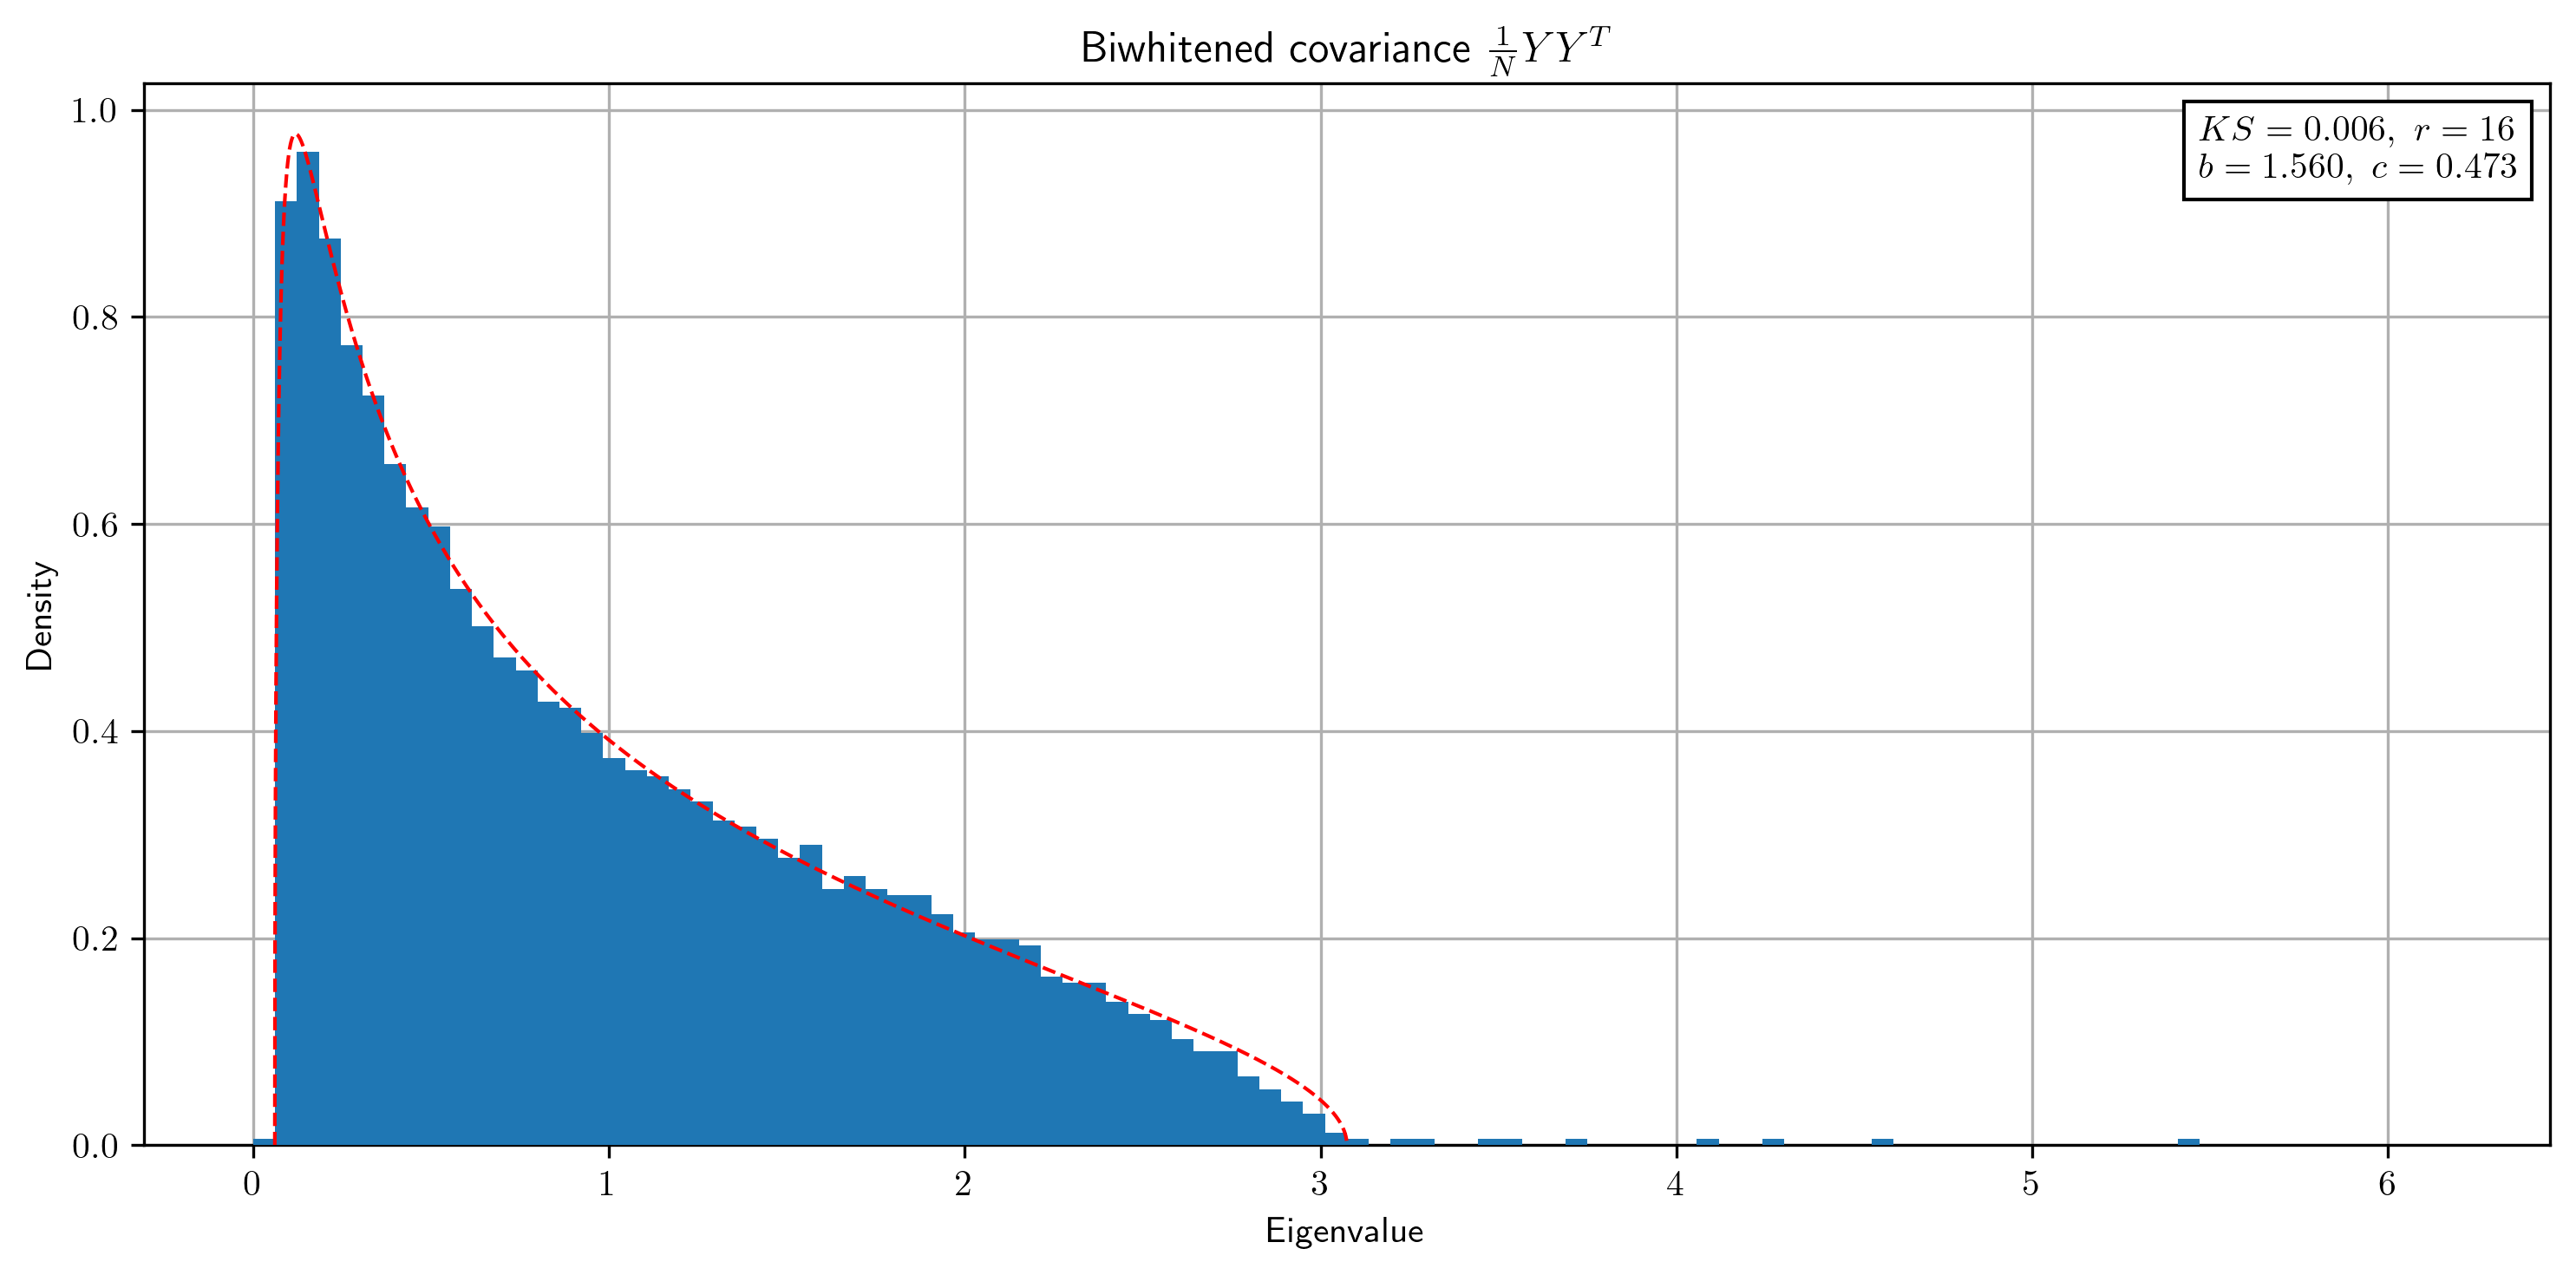

In [26]:
# get MP
plotting.MP_histograms_from_bipca(adata,median=False,bins=100) 

In [25]:
adata

AnnData object with n_obs × n_vars = 2700 × 4758
    var: 'gene_ids'
    uns: 'bipca'
    obsm: 'U_biwhite'
    varm: 'V_biwhite'
    layers: 'Y_biwhite', 'Z_biwhite'

### 4. use bipca output for downstream analysis with scanpy

#### get low dimensional representations

In [28]:
from bipca.experiments import new_svd as SVD
adata.obsm['pcs'] = SVD(adata.layers['Z_biwhite'],adata.uns["bipca"]['rank'])


Calculating rank k=2700 dense exact singular value decomposition using __compute_torch_svd....
Calculated rank k=2700 dense exact singular value decomposition using __compute_torch_svd. in 1.21 seconds.


#### clustering

In [29]:
sc.pp.neighbors(adata,
                use_rep = "pcs",method="gauss",
                n_pcs=adata.uns["bipca"]['rank'])

In [45]:
sc.tl.leiden(adata,
                resolution=0.5,
                random_state=42
            )

#### t-SNE visualization

In [31]:
from openTSNE import TSNE
adata.obsm['tsne'] = np.array(TSNE(n_jobs=16).fit(adata.obsm['pcs']))

/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/conda/envs/bipca-experiment/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


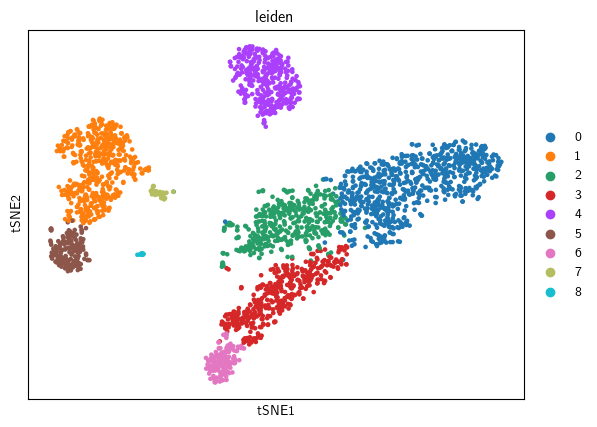

In [46]:
sc.pl.embedding(adata,basis="tsne",color="leiden")

#### visualize marker gene expressions

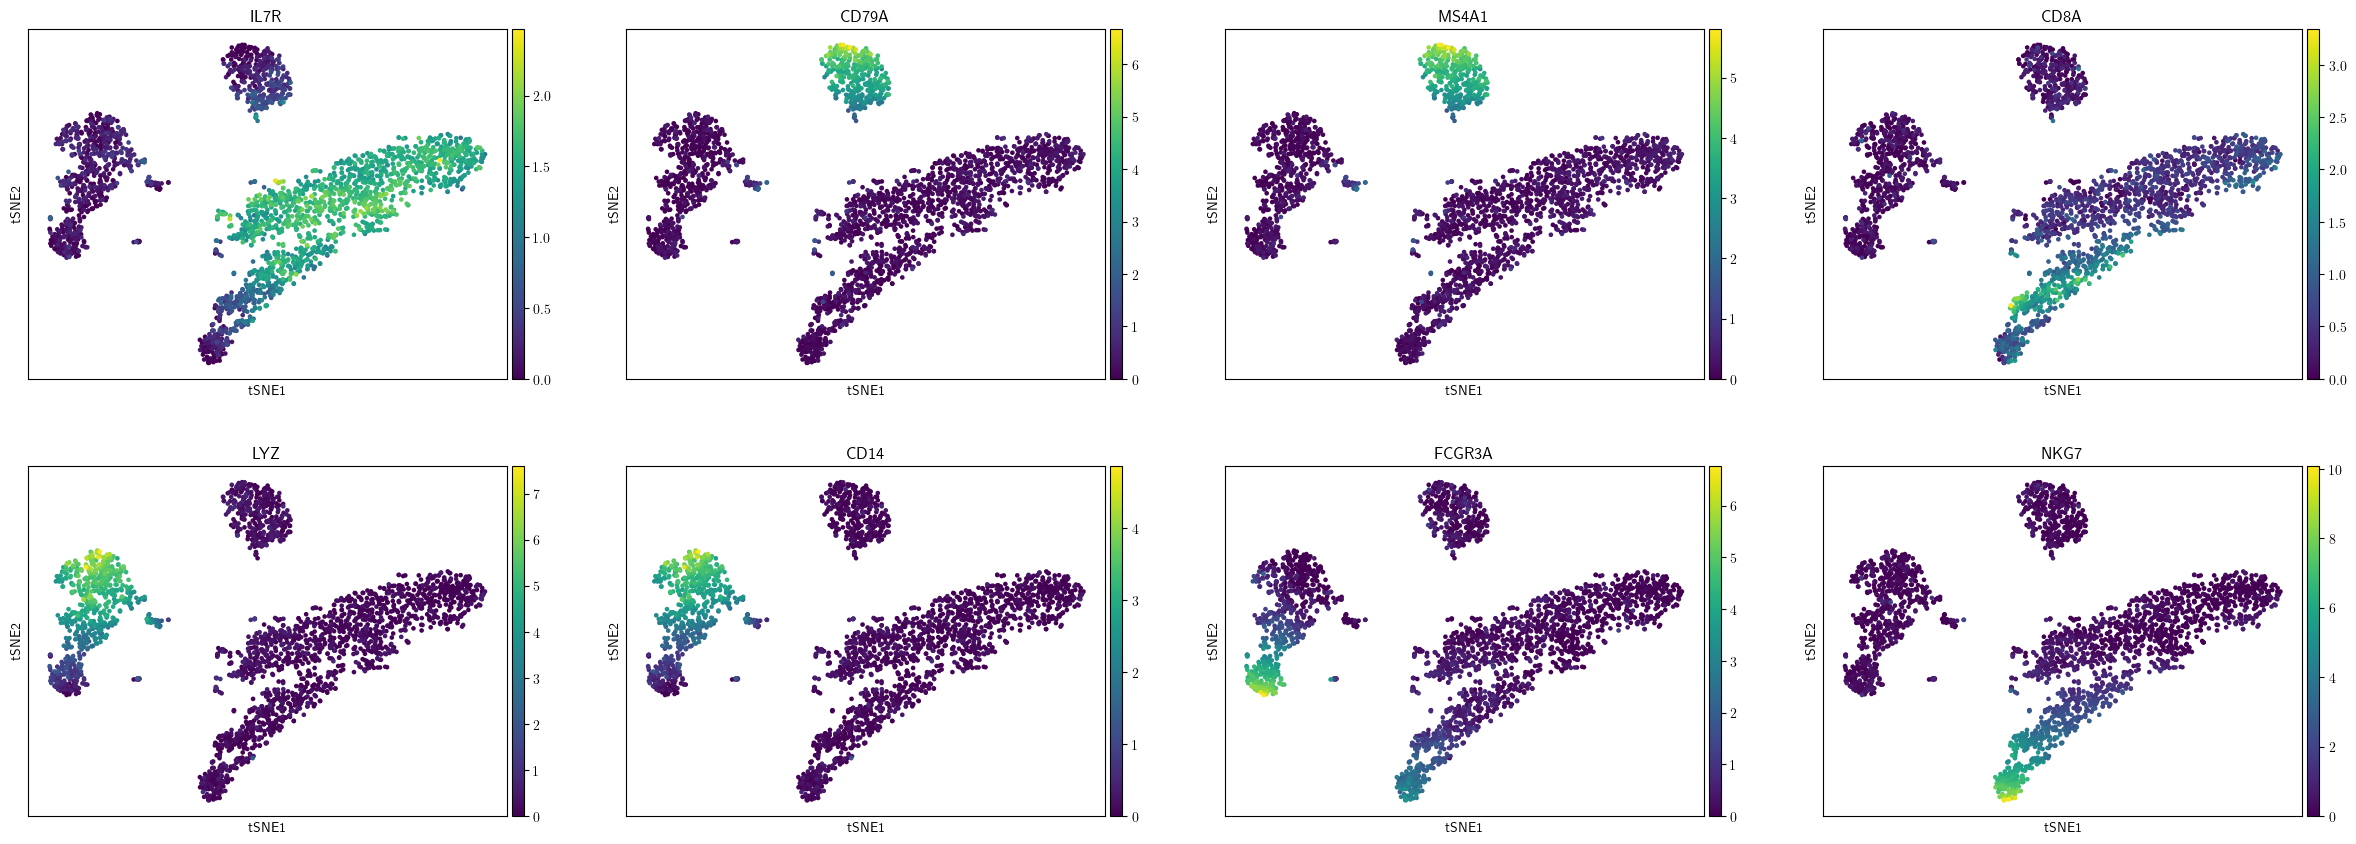

In [49]:
marker_genes = ["IL7R","CD79A","MS4A1","CD8A","LYZ","CD14","FCGR3A","NKG7"]
sc.pl.embedding(adata,basis="tsne",color=marker_genes,layer="Z_biwhite")